## 8 Aug 2018
-- Laurin Gray

This is a notebook to make the plots for posters, papers, & presentations.  The catalogs used for plotting the layers have had contaminants removed, and the confirmed AGBs are spectroscopically determined with the highest degree of confidence from Kacharov et al. 2012, matched to our sources & magnitudes.

Plots:
- 1 figure with all 8 CMDs (2x4, 3x3, & 4x2)
- K vs. J-K with 3-sig line, 6+ source layers, color cuts, &/or confirmed AGBs (square & wide)
- [8.0] vs. [3.6]-[8.0] with 3-sig line, in_8 sources, & bottom boundary (square & wide)
- [8.0] vs. [3.6]-[8.0] Hess diagram

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
import csv
import pathlib

In [2]:
# Read in my data from a .csv file saved locally.

# all sources
phot_data = pd.read_csv('~/Documents/Phot_data/CMDparameters26June2018_lauringray.csv')


# Source catalogs
in8 = pd.read_csv('/Users/lgray/Documents/Phot_data/Red_Cand_Catalogs/8Aug2018/8Aug2018_LG_RedCand_8.csv')
in7 = pd.read_csv('/Users/lgray/Documents/Phot_data/Red_Cand_Catalogs/8Aug2018/8Aug2018_LG_RedCand_7.csv')
in6 = pd.read_csv('/Users/lgray/Documents/Phot_data/Red_Cand_Catalogs/8Aug2018/8Aug2018_LG_RedCand_6.csv')

# Confirmed AGBs
C_AGBs = pd.read_csv('/Users/lgray/Documents/Phot_data/NGC6822_3Aug2018_CAGB_Matches_lauringray.csv')
M_AGBs = pd.read_csv('/Users/lgray/Documents/Phot_data/NGC6822_3Aug2018_MAGB_Matches_lauringray.csv')


In [3]:
# Create all color cuts needed for plotting

phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
#
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
#
phot_data['jMINUSthreesix'] = phot_data.Jmag.values - phot_data.k36mag.values
#
phot_data['hMINUSthreesix'] = phot_data.Hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.Hmag.values - phot_data.k45mag.values

In [4]:
# Some values in the tables are +/- 9999, due to null data from combining the tables, 
# which throws off the color scaling.  We wish to exclude these values, 
# which we do by cutting to only include values in the range -500:500

filter_phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]

filter_in8 = in8[(in8 < 500.0) & (in8 > -500.0)]
filter_in7 = in7[(in7 < 500.0) & (in7 > -500.0)]
filter_in6 = in6[(in6 < 500.0) & (in6 > -500.0)]

filter_CAGB = C_AGBs[(C_AGBs < 500.0) & (C_AGBs > -500.0)]
filter_MAGB = M_AGBs[(M_AGBs < 500.0) & (M_AGBs > -500.0)]


In [5]:
# For ease in calling functions, we rename all the value arrays to exclude filter_phot_data._____.values
# Because there's so many, I'm only defining ones I'll probably need- I can add any later

# Magnitudes
threesix = filter_phot_data.k36mag.values
eightzero = filter_phot_data.k80mag.values
Hmag = filter_phot_data.Hmag.values
Kmag = filter_phot_data.Kmag.values

C_Kmag = filter_CAGB.Kmag.values
M_Kmag = filter_MAGB.Kmag.values

in8_eightzero = filter_in8.k80mag.values
in8_Kmag = filter_in8.Kmag.values
in7_Kmag = filter_in7.Kmag.values
in6_Kmag = filter_in6.Kmag.values


# Colors
threesixMINUSeightzero = filter_phot_data.threesixMINUSeightzero.values

fourfiveMINUSeightzero = filter_phot_data.fourfiveMINUSeightzero.values

jMINUSthreesix = filter_phot_data.jMINUSthreesix.values
jMINUSh = filter_phot_data.jMINUSh.values
jMINUSk = filter_phot_data.jMINUSk.values

hMINUSthreesix = filter_phot_data.hMINUSthreesix.values
hMINUSfourfive = filter_phot_data.hMINUSfourfive.values
hMINUSk = filter_phot_data.hMINUSk.values

C_jMINUSk = filter_CAGB.jMINUSk.values
M_jMINUSk = filter_MAGB.jMINUSk.values

in8_threesixMINUSeightzero = in8.threesixMINUSeightzero.values
in8_jMINUSk = in8.jMINUSk.values
in7_jMINUSk = in7.jMINUSk.values
in6_jMINUSk = in6.jMINUSk.values



In [6]:
def plot_CMD(xaxis, yaxis, color='grey', y1=7.0, y2=21.5, x1=-3.0, x2=14.5, xlabel='', ylabel='', wide=False):
    """
    Plot a CMD. Default color is grey for better visibility when overplotting flagged points in color.
    
    Note that axes limits/labels are pre-defined for the 8 CMDs that were checked, but if plotting a different CMD, 
    the axis limits and labels can be manually defined.  The defaults are the biggest possible in case the user
    doesn't already know which limits to use, so they can see the full image.  
    
    Note that a pre-set axis may not automatically have the correct limits- the limits are set for a specific CMD,
    and can differ for different CMDs
    
    Call example:
        plot_CMD(xaxis, yaxis)
        OR
        plot_CMD(threesixMINUSfourfive, threesix, color='grey', y1=7.5, y2=21.5, x1=-3.0, x2=2.5, 
                xlabel='[3.6] - [4.5]', ylabel='[3.6]')
    """
    
    # pre-sets for the 8 CMDs so I can call them quickly
    if yaxis is eightzero and xaxis is threesixMINUSeightzero:
        y1 = 9.0
        y2 = 18.0
        ylabel = '[8.0]'
        x1 = -2.0
        x2 = 7.5
        xlabel = '[3.6] - [8.0]'
    elif yaxis is eightzero and xaxis is fourfiveMINUSeightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
        x1 = -1.5
        x2 = 6.5
        xlabel = '[4.5] - [8.0]'
    elif yaxis is Hmag and xaxis is jMINUSh:
        y1 = 11.5
        y2 = 19.0
        ylabel = '$H$'
        x1 = -0.5
        x2 = 2.5
        xlabel = '$J$ - $H$'
    elif yaxis is Hmag and xaxis is hMINUSthreesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = '$H$'
        x1 = -1.5
        x2 = 4.0
        xlabel = '$H$ - [3.6]'
    elif yaxis is Hmag and xaxis is hMINUSfourfive:
        y1 = 11.5
        y2 = 19.0
        ylabel = '$H$'
        x1 = -2.5
        x2 = 5.0
        xlabel = '$H$ - [4.5]'
    elif yaxis is Kmag and xaxis is hMINUSk:
        y1 = 11.5
        y2 = 19.0
        ylabel = '$K_s$'
        x1 = -0.5
        x2 = 2.0
        xlabel = '$H$ - $K_s$'
    elif yaxis is Kmag and xaxis is jMINUSk:
        y1 = 11.5
        y2 = 18.5
        ylabel = '$K_s$'
        x1 = -0.5
        x2 = 4.0
        xlabel = '$J$ - $K_s$'
    elif yaxis is threesix and xaxis is jMINUSthreesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = '[3.6]'
        x1 = -0.5
        x2 = 6.0
        xlabel = '$J$ - [3.6]'
    else:
        print("That CMD is not automatically included, using defaults or manually entered values")
    
    if wide is True:
        plt.figure(figsize=(20,12))
        plt.xlabel(xlabel, size=24)
        plt.ylabel(ylabel, size=24)
        plt.tick_params(labelsize=16)
    else:
        plt.figure(figsize=(12,12))
        plt.xlabel(xlabel, size=26)
        plt.ylabel(ylabel, size=26)
        plt.tick_params(labelsize=14)
    
    plt.plot(xaxis,yaxis,',', color=color, ms=3)
    plt.xlim(x1, x2)
    plt.ylim(y2, y1)
    

In [7]:
def plot_red_layers(x_flags, y_flags, colors='consistent', legend=True, wide=False):
    """
    User creates two lists containing all of the flagged x and y points that were separately saved. 
    The function then iterates through that list and scatterplots each set in a different color.
    
    This function also requires user to create a col_names list containing the names of each column included in the 
    final plot in string form.
    
    The user can choose whether to assign colors evenly based on the number of columns plotted, 
    or to keep the same colors with each column no matter how many there are.  
    To assign evenly, set colors='even'; for consistent, colors='consistent'.  The default is consistent
    
    Call example: 
        col_names = ['in_eight', 'in_seven', 'in_six', 'in_five', 'in_four']
        x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
        y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]
        plot_red_layers(x_flags, y_flags)
    """
    
    if colors is 'even':
        number = len(x_flags)  # for even color assignment
        cmap = plt.get_cmap('hsv')
        colors = [cmap(i) for i in np.linspace(0, 1, number)]  # for even color assignment
    elif colors is 'consistent':
        cmap = plt.get_cmap('hsv')
        colors = [cmap(i) for i in np.linspace(0, 1, 4)] # for consistent color assignment
    
    k = 0
    
    if wide is True:
        for i in x_flags:
            plt.scatter(x_flags[k], y_flags[k], c=colors[k], label=col_names[k], s=24)
            k = k+1
    else:
        for i in x_flags:
            plt.scatter(x_flags[k], y_flags[k], c=colors[k], label=col_names[k], s=14)
            k = k+1
            
    if legend is True:
        plt.legend(loc='upper right', fontsize=16, markerscale=3)

In [8]:
def plot_hess(xaxis, yaxis, y1=7.0, y2=21.5, x1=-3.0, x2=14.5, xlabel='', ylabel=''):
    """
    Plots a Hess diagram for the CMD.  Only has auto x-axis & y-axis info for the 8 selected CMDs, 
    user can specify their own axes limits in the code (defaults are biggest possible) & the axes labels in a string.
    
    Note that axes limits/labels are pre-defined for the 8 CMDs that were checked, but if plotting a different CMD, 
    the axis limits and labels can be manually defined.  The defaults are the biggest possible in case the user
    doesn't already know which limits to use, so they can see the full image.  
    
    Call example:
        plot_hess(threesixMINUSeightzero, eightzero)
        OR
        plot_hess(threesixMINUSfourfive, threesix, y1=7.5, y2=21.5, x1=-3.0, x2=2.5, 
                xlabel='[3.6] - [4.5]', ylabel='[3.6]')
    """
    
    if yaxis is eightzero and xaxis is threesixMINUSeightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
        x1 = -2.0
        x2 = 7.5
        xlabel = '[3.6] - [8.0]'
    elif yaxis is eightzero and xaxis is fourfiveMINUSeightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
        x1 = -1.5
        x2 = 6.5
        xlabel = '[4.5] - [8.0]'
    elif yaxis is Hmag and xaxis is jMINUSh:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
        x1 = -0.5
        x2 = 2.5
        xlabel = 'J - H'
    elif yaxis is Hmag and xaxis is hMINUSthreesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
        x1 = -1.5
        x2 = 4.0
        xlabel = 'H - [3.6]'
    elif yaxis is Hmag and xaxis is hMINUSfourfive:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
        x1 = -2.5
        x2 = 5.0
        xlabel = 'H - [4.5]'
    elif yaxis is Kmag and xaxis is hMINUSk:
        y1 = 11.5
        y2 = 19.0
        ylabel = '$K_s$'
        x1 = -0.5
        x2 = 2.0
        xlabel = 'H - $K_s$'
    elif yaxis is Kmag and xaxis is jMINUSk:
        y1 = 11.5
        y2 = 19.0
        ylabel = '$K_s$'
        x1 = -0.5
        x2 = 4.0
        xlabel = 'J - $K_s$'
    elif yaxis is threesix and xaxis is jMINUSthreesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = '[3.6]'
        x1 = -0.5
        x2 = 6.0
        xlabel = 'J - [3.6]'
    else:
        print("That CMD is not automatically included, using defaults or manually entered values")
    
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))
    plt.xlim(x1, x2)
    plt.ylim(y2, y1)
    im1 = ax1.hexbin(xaxis, yaxis, bins='log', cmap=plt.cm.viridis,
                   mincnt=1, extent=(x1, x2, y2, y1))
    ax1.set_xlabel(xlabel, size=24)
    ax1.set_ylabel(ylabel, size=24)
    cb = plt.colorbar(im1, label='log(N)')
    ax1.tick_params(labelsize=14)

In [9]:
col_names = ['High confidence', 'Medium confidence', 'Low confidence']

## K vs. J-K

### Plain, wide (presentation)

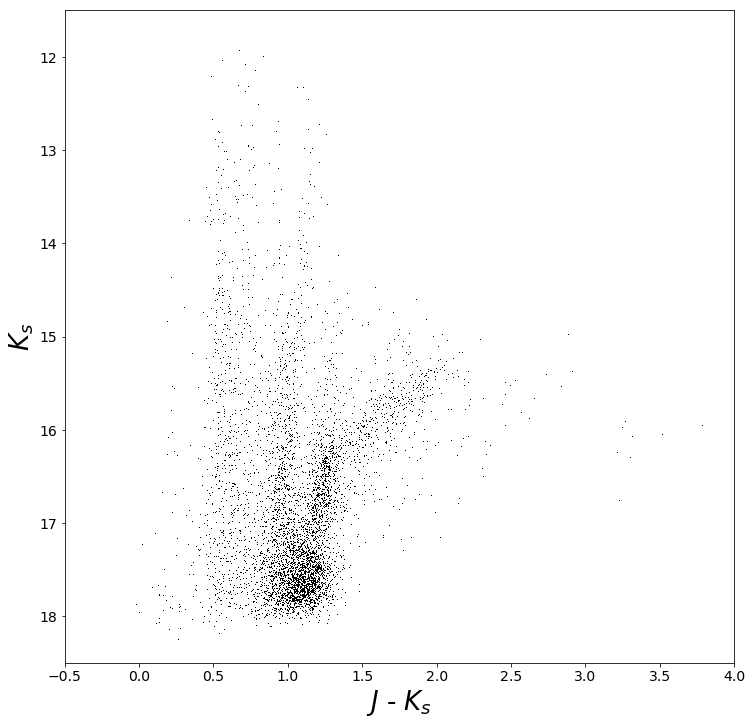

In [10]:
xaxis = jMINUSk
yaxis = Kmag

plot_CMD(xaxis, yaxis, 'black')

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/K_vs_J-K_plain.pdf')

### 3-sig, vertical mean, wide, in black (presentation)

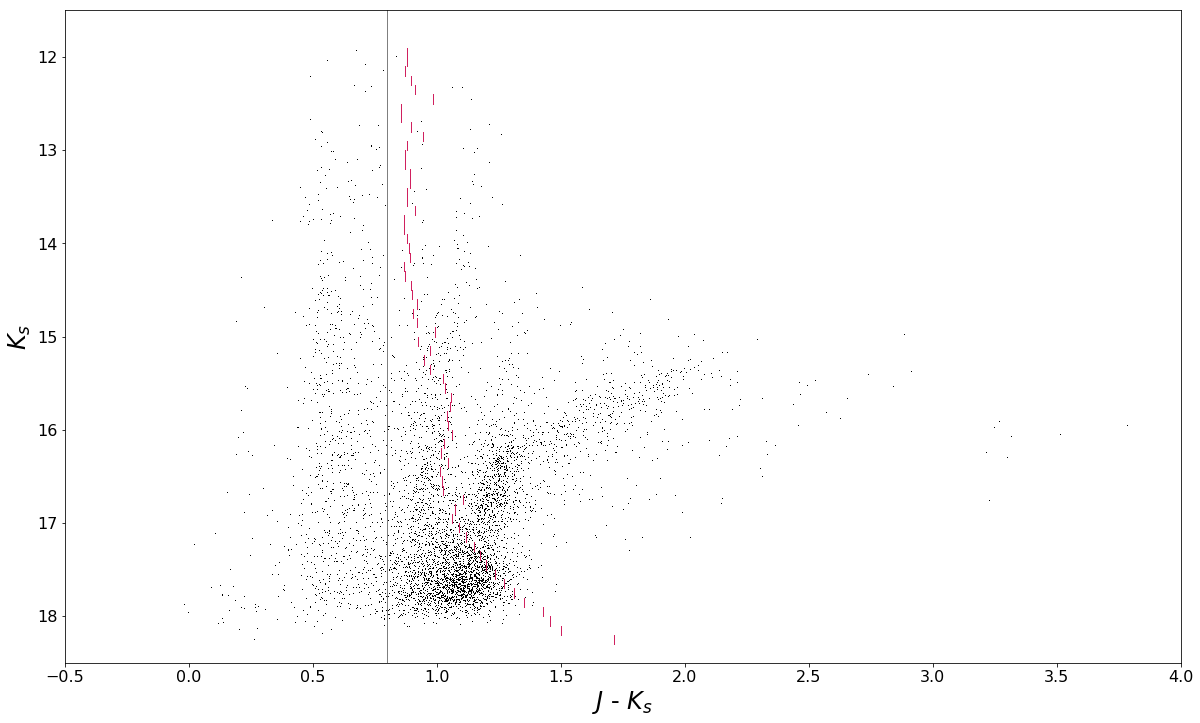

In [11]:
xaxis = jMINUSk
yaxis = Kmag


plot_CMD(xaxis, yaxis, 'black', wide=True)

# 3-sigma line

redlim = [0.879895737662863, 0.8775924141636695, 0.8715707399707953, 
          0.8966725108531585, 0.9134534593651035, 0.9861642664403921, 0.8537197213938452, 
          0.8563514138914667, 0.8941956336486122, 0.9450078882716745, 0.8793135747862142, 
          0.8707045601520763, 0.8715208001858594, 0.8930588828268777, 0.8930080333111907, 
          0.8807308795514384, 0.8794535168895976, 0.9136080238527742, 0.8675755503981238, 
          0.8657623583369101, 0.881141593299356, 0.8869514024244964, 0.8923249691766746, 
          0.8656738054100351, 0.8697298533798425, 0.8958369977858692, 0.9002811788375211, 
          0.9182890033362764, 0.9048369520711795, 0.9213593947007497, 0.990804271229887, 
          0.9217934315691899, 0.9725898076646317, 0.9485478157675951, 0.971711498897255, 
          1.026288107882921, 1.0323488859538545, 1.0555758430921671, 1.0528741347386188, 
          1.0392519254971446, 1.0457953480186524, 1.0612945112049388, 1.0288953191907302, 
          1.0181779760618879, 1.0432569065443091, 1.012174119179027, 1.0212031855313928, 
          1.0246731251321948, 1.1041754291004438, 1.0717615636187845, 1.0628049070679086, 
          1.0880419155197154, 1.1189452857610653, 1.149550536937374, 1.1719984394084637, 
          1.1986549235220831, 1.2329174613158713, 1.2713571498158842, 1.3091029760267063, 
          1.3501949703948366, 1.4283615588992815, 1.455833084437395, 1.5004615175524838, 
          1.7155950033724958]

y1 = 11.9 # resets at beginning of first y-bin

for x in redlim:
    plt.plot((x,x), (y1, y1+0.1), c='#d0205e', linewidth='1')
    y1 = y1 + 0.1

plt.axvline(x=0.7973548387096774, c='#7f7f7f', linewidth=1)

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/K_vs_J-K_3sig.pdf')

### 3-sig, color cuts, layers (poster)

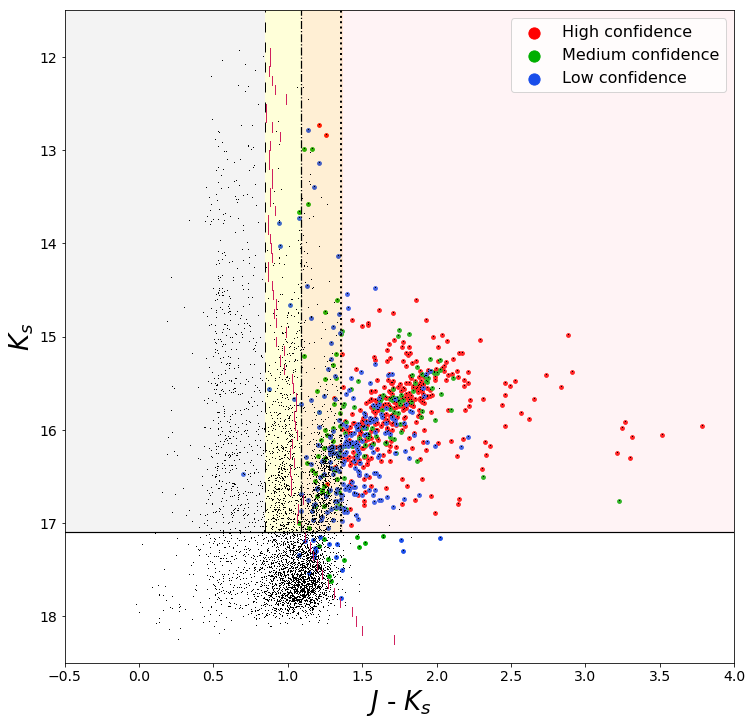

In [12]:
xaxis = jMINUSk
yaxis = Kmag

x_flag_8 = in8_jMINUSk
y_flag_8 = in8_Kmag
x_flag_7 = in7_jMINUSk
y_flag_7 = in7_Kmag
x_flag_6 = in6_jMINUSk
y_flag_6 = in6_Kmag


x_flags = [x_flag_8, x_flag_7, x_flag_6]
y_flags = [y_flag_8, y_flag_7, y_flag_6]

plot_CMD(xaxis, yaxis, 'black')


# 3-sigma line
redlim = [0.879895737662863, 0.8775924141636695, 0.8715707399707953, 
          0.8966725108531585, 0.9134534593651035, 0.9861642664403921, 0.8537197213938452, 
          0.8563514138914667, 0.8941956336486122, 0.9450078882716745, 0.8793135747862142, 
          0.8707045601520763, 0.8715208001858594, 0.8930588828268777, 0.8930080333111907, 
          0.8807308795514384, 0.8794535168895976, 0.9136080238527742, 0.8675755503981238, 
          0.8657623583369101, 0.881141593299356, 0.8869514024244964, 0.8923249691766746, 
          0.8656738054100351, 0.8697298533798425, 0.8958369977858692, 0.9002811788375211, 
          0.9182890033362764, 0.9048369520711795, 0.9213593947007497, 0.990804271229887, 
          0.9217934315691899, 0.9725898076646317, 0.9485478157675951, 0.971711498897255, 
          1.026288107882921, 1.0323488859538545, 1.0555758430921671, 1.0528741347386188, 
          1.0392519254971446, 1.0457953480186524, 1.0612945112049388, 1.0288953191907302, 
          1.0181779760618879, 1.0432569065443091, 1.012174119179027, 1.0212031855313928, 
          1.0246731251321948, 1.1041754291004438, 1.0717615636187845, 1.0628049070679086, 
          1.0880419155197154, 1.1189452857610653, 1.149550536937374, 1.1719984394084637, 
          1.1986549235220831, 1.2329174613158713, 1.2713571498158842, 1.3091029760267063, 
          1.3501949703948366, 1.4283615588992815, 1.455833084437395, 1.5004615175524838, 
          1.7155950033724958]

y1 = 11.9 # resets at beginning of first y-bin

for x in redlim:
    plt.plot((x,x), (y1, y1+0.1), c='#d0205e', linewidth='1')
    y1 = y1 + 0.1


# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red', '#00af00', '#194dea'])


# Shaded regions
plt.axvspan(xmin=-0.5, xmax=0.85, ymin=0.2, alpha=0.25, fc='lightgrey') # foreground contamination
plt.axvspan(xmin=0.85, xmax=1.09, ymin=0.2, alpha=0.15, fc='yellow') # RSGs? 
plt.axvspan(xmin=1.09, xmax=1.37, ymin=0.2, alpha=0.17, fc='orange') # O-AGBs
plt.axvspan(xmin=1.36, xmax=4.0, ymin=0.2, alpha=0.18, fc='pink') # C-AGBs


# Color cuts
plt.axvline(x=0.85, ymin=0.2, linewidth=1, color='black', ls='dashed', dashes=[10,10]) # foreground limit
plt.axvline(x=1.09, ymin=0.2, linewidth=1.25, color='black', ls='-.') # blue O-AGB limit
plt.axvline(x=1.36, ymin=0.2, linewidth=2, color='black', ls='dotted', ms=10) # C/O sep
plt.axhline(y=17.1, linewidth=1.2, color='black') # TRGB (compared to Sibbons+ 2012 visually, & from C&H 2005)


#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/K_vs_J-K_poster.pdf')

### 3-sig, color cuts, layers, confirmed AGBs

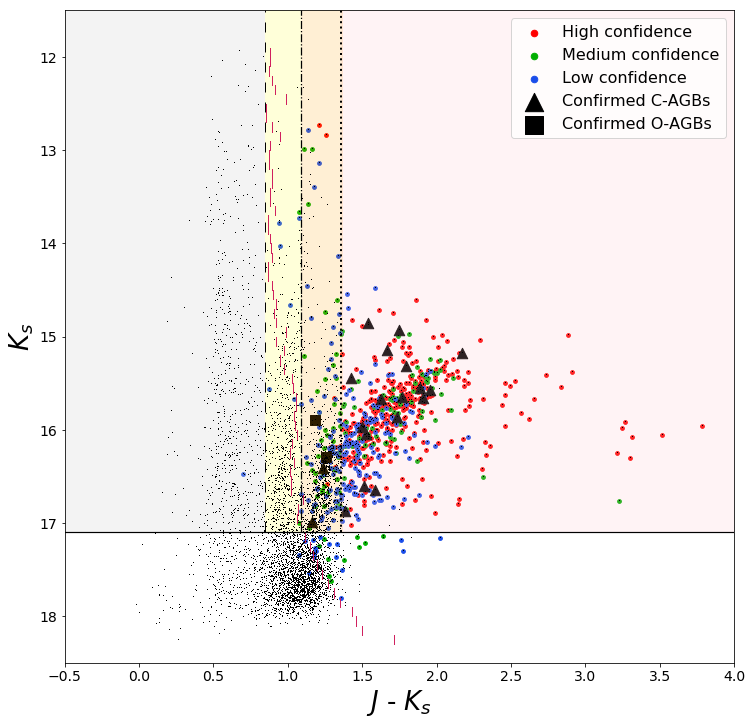

In [13]:
xaxis = jMINUSk
yaxis = Kmag

x_flag_8 = in8_jMINUSk
y_flag_8 = in8_Kmag
x_flag_7 = in7_jMINUSk
y_flag_7 = in7_Kmag
x_flag_6 = in6_jMINUSk
y_flag_6 = in6_Kmag

x_flags = [x_flag_8, x_flag_7, x_flag_6]
y_flags = [y_flag_8, y_flag_7, y_flag_6]

plot_CMD(xaxis, yaxis, 'black')


# 3-sigma line
redlim = [0.879895737662863, 0.8775924141636695, 0.8715707399707953, 
          0.8966725108531585, 0.9134534593651035, 0.9861642664403921, 0.8537197213938452, 
          0.8563514138914667, 0.8941956336486122, 0.9450078882716745, 0.8793135747862142, 
          0.8707045601520763, 0.8715208001858594, 0.8930588828268777, 0.8930080333111907, 
          0.8807308795514384, 0.8794535168895976, 0.9136080238527742, 0.8675755503981238, 
          0.8657623583369101, 0.881141593299356, 0.8869514024244964, 0.8923249691766746, 
          0.8656738054100351, 0.8697298533798425, 0.8958369977858692, 0.9002811788375211, 
          0.9182890033362764, 0.9048369520711795, 0.9213593947007497, 0.990804271229887, 
          0.9217934315691899, 0.9725898076646317, 0.9485478157675951, 0.971711498897255, 
          1.026288107882921, 1.0323488859538545, 1.0555758430921671, 1.0528741347386188, 
          1.0392519254971446, 1.0457953480186524, 1.0612945112049388, 1.0288953191907302, 
          1.0181779760618879, 1.0432569065443091, 1.012174119179027, 1.0212031855313928, 
          1.0246731251321948, 1.1041754291004438, 1.0717615636187845, 1.0628049070679086, 
          1.0880419155197154, 1.1189452857610653, 1.149550536937374, 1.1719984394084637, 
          1.1986549235220831, 1.2329174613158713, 1.2713571498158842, 1.3091029760267063, 
          1.3501949703948366, 1.4283615588992815, 1.455833084437395, 1.5004615175524838, 
          1.7155950033724958]

y1 = 11.9 # resets at beginning of first y-bin

for x in redlim:
    plt.plot((x,x), (y1, y1+0.1), c='#d0205e', linewidth='1')
    y1 = y1 + 0.1


# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red', '#00af00', '#194dea'])


# Shaded regions
plt.axvspan(xmin=-0.5, xmax=0.85, ymin=0.2, alpha=0.25, fc='lightgrey') # foreground contamination
plt.axvspan(xmin=0.85, xmax=1.09, ymin=0.2, alpha=0.15, fc='yellow') # RSGs? 
plt.axvspan(xmin=1.09, xmax=1.37, ymin=0.2, alpha=0.17, fc='orange') # O-AGBs
plt.axvspan(xmin=1.36, xmax=4.0, ymin=0.2, alpha=0.18, fc='pink') # C-AGBs


# Color cuts
plt.axvline(x=0.85, ymin=0.2, linewidth=1, color='black', ls='dashed', dashes=[10,10]) # foreground limit
plt.axvline(x=1.09, ymin=0.2, linewidth=1.25, color='black', ls='-.') # blue O-AGB limit
plt.axvline(x=1.36, ymin=0.2, linewidth=2, color='black', ls='dotted', ms=10) # C/O sep
plt.axhline(y=17.1, linewidth=1.2, color='black') # TRGB (compared to Sibbons+ 2012 visually, & from C&H 2005)


# Confirmed AGBs (from Kacharov et al. 2012)
plt.scatter(C_jMINUSk, C_Kmag, color='black', marker='^', s=110, label='Confirmed C-AGBs')
plt.scatter(M_jMINUSk, M_Kmag, color='black', marker='s', s=95, label='Confirmed O-AGBs')
plt.legend(loc='upper right', fontsize=16, markerscale=1.75)

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/K_vs_J-K_poster_withConfirm.pdf')

### Color cuts, layers, wide (my presentation)

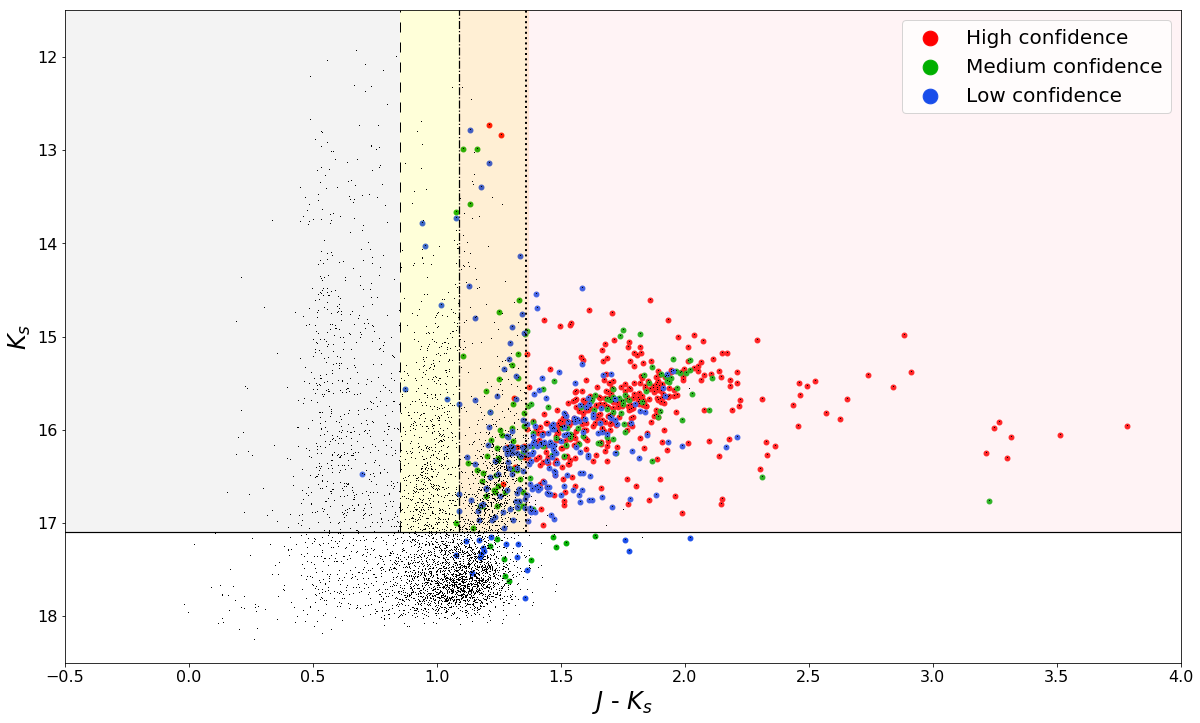

In [14]:
xaxis = jMINUSk
yaxis = Kmag

x_flag_8 = in8_jMINUSk
y_flag_8 = in8_Kmag
x_flag_7 = in7_jMINUSk
y_flag_7 = in7_Kmag
x_flag_6 = in6_jMINUSk
y_flag_6 = in6_Kmag

x_flags = [x_flag_8, x_flag_7, x_flag_6]
y_flags = [y_flag_8, y_flag_7, y_flag_6]

plot_CMD(xaxis, yaxis, 'black', wide=True)


# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red', '#00af00', '#194dea'], wide=True)
plt.legend(loc='upper right', fontsize=20, markerscale=3)


# Shaded regions
plt.axvspan(xmin=-0.5, xmax=0.85, ymin=0.2, alpha=0.25, fc='lightgrey') # foreground contamination
plt.axvspan(xmin=0.85, xmax=1.09, ymin=0.2, alpha=0.15, fc='yellow') # RSGs? 
plt.axvspan(xmin=1.09, xmax=1.37, ymin=0.2, alpha=0.17, fc='orange') # O-AGBs
plt.axvspan(xmin=1.36, xmax=4.0, ymin=0.2, alpha=0.18, fc='pink') # C-AGBs


# Color cuts
plt.axvline(x=0.85, ymin=0.2, linewidth=1, color='black', ls='dashed', dashes=[10,10]) # foreground limit
plt.axvline(x=1.09, ymin=0.2, linewidth=1.25, color='black', ls='-.') # blue O-AGB limit
plt.axvline(x=1.36, ymin=0.2, linewidth=2, color='black', ls='dotted', ms=10) # C/O sep
plt.axhline(y=17.1, linewidth=1.2, color='black') # TRGB (compared to Sibbons+ 2012 visually, & from C&H 2005)


#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/K_vs_J-K_present_wide.pdf')

### Color cuts, layers, wide, confirmed AGBs (presentation)

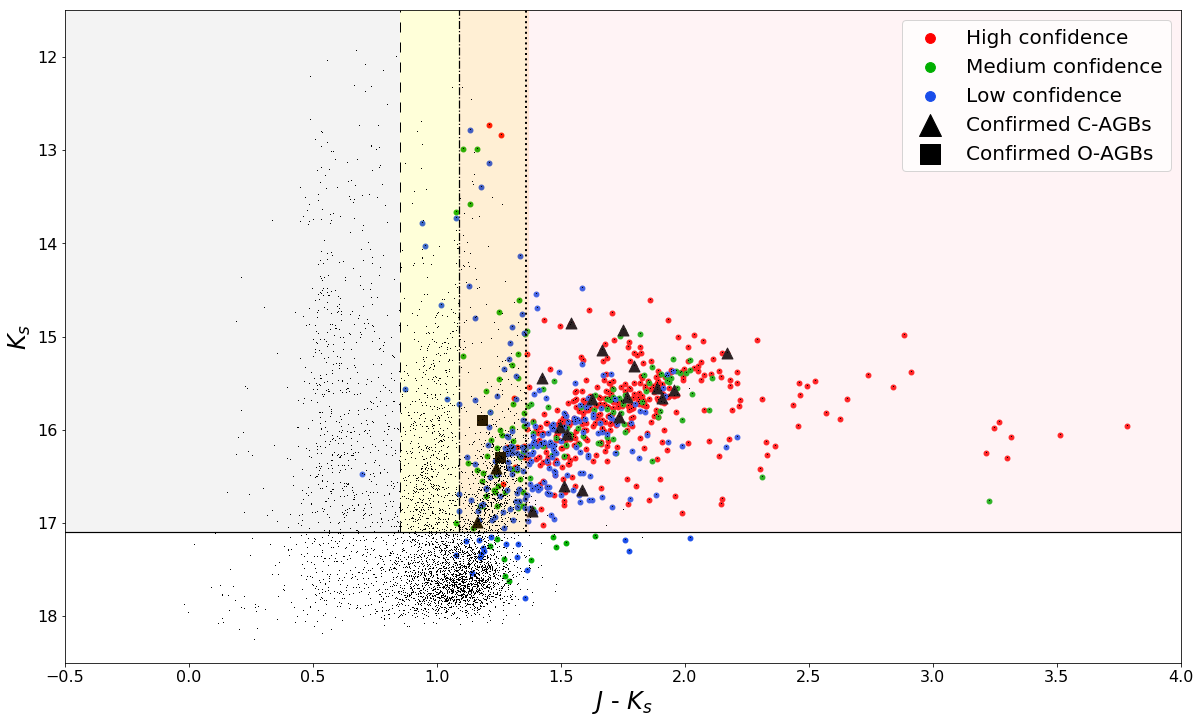

In [15]:
xaxis = jMINUSk
yaxis = Kmag

x_flag_8 = in8_jMINUSk
y_flag_8 = in8_Kmag
x_flag_7 = in7_jMINUSk
y_flag_7 = in7_Kmag
x_flag_6 = in6_jMINUSk
y_flag_6 = in6_Kmag

x_flags = [x_flag_8, x_flag_7, x_flag_6]
y_flags = [y_flag_8, y_flag_7, y_flag_6]

plot_CMD(xaxis, yaxis, 'black', wide=True)


# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red', '#00af00', '#194dea'], wide=True)


# Shaded regions
plt.axvspan(xmin=-0.5, xmax=0.85, ymin=0.2, alpha=0.25, fc='lightgrey') # foreground contamination
plt.axvspan(xmin=0.85, xmax=1.09, ymin=0.2, alpha=0.15, fc='yellow') # RSGs? 
plt.axvspan(xmin=1.09, xmax=1.37, ymin=0.2, alpha=0.17, fc='orange') # O-AGBs
plt.axvspan(xmin=1.36, xmax=4.0, ymin=0.2, alpha=0.18, fc='pink') # C-AGBs


# Color cuts
plt.axvline(x=0.85, ymin=0.2, linewidth=1, color='black', ls='dashed', dashes=[10,10]) # foreground limit
plt.axvline(x=1.09, ymin=0.2, linewidth=1.25, color='black', ls='-.') # blue O-AGB limit
plt.axvline(x=1.36, ymin=0.2, linewidth=2, color='black', ls='dotted', ms=10) # C/O sep
plt.axhline(y=17.1, linewidth=1.2, color='black') # TRGB (compared to Sibbons+ 2012 visually, & from C&H 2005)


# Confirmed AGBs (from Kacharov et al. 2012)
plt.scatter(C_jMINUSk, C_Kmag, color='black', marker='^', s=120, label='Confirmed C-AGBs')
plt.scatter(M_jMINUSk, M_Kmag, color='black', marker='s', s=110, label='Confirmed O-AGBs')
plt.legend(loc='upper right', fontsize=20, markerscale=2)


#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/K_vs_J-K_present_wide_withConfirm.pdf')

## [8.0] vs. [3.6] - [8.0]

### 3-sig, vertical mean, in_8

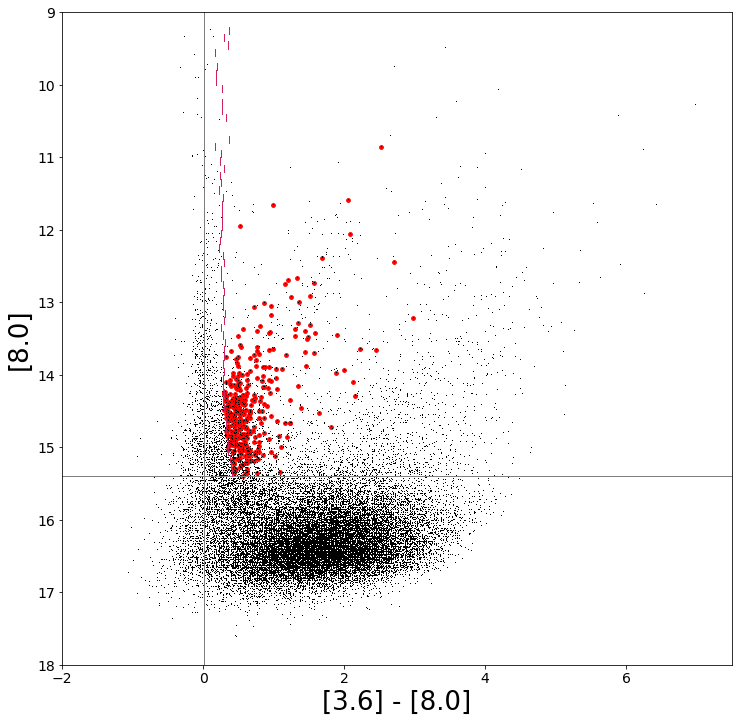

In [16]:
xaxis = threesixMINUSeightzero
yaxis = eightzero

x_flag_8 = in8_threesixMINUSeightzero
y_flag_8 = in8_eightzero

x_flags = [x_flag_8]
y_flags = [y_flag_8]

plot_CMD(xaxis, yaxis, 'black')

# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red'], legend=False) # turned off legend because it's redundant

redlim = [0.3711409973215888, 0.30097809756457605, 0.35941125496954285, 0.17, 9999, 0.19826699071362391, 
          0.18155494421403515, 0.1842626692942798, 0.2745584412271571, 9999, 0.26530073656834885, 
          0.272651461195151, 0.31928552015092915, 9999, 9999, 0.36205262752974143, 0.17, 0.25252019000527776, 
          0.24707130299064803, 0.295659679907019, 0.24320302549483297, 0.2537867860719714, 0.22868236931069777, 
          0.2851997273543948, 0.2685502607055788, 0.265899974389507, 0.2661298512232694, 0.27599045756789276, 
          0.25218923806570537, 0.242759264797387, 0.23297381391024516, 0.28955472746417554, 0.3017461462368922, 
          0.2485548926578606, 0.2562745719249429, 0.2776816963099864, 0.2926236494851574, 0.2816920066016876, 
          0.28347399431682363, 0.3062331627082658, 0.2912372550650325, 0.24854716429198767, 0.28764476067096034, 
          0.3182464457801656, 0.2914889006326318, 0.297582181808883, 0.2847097180473308, 0.2967128013232641, 
          0.28718405192714985, 0.28915906824344656, 0.2995616933161593, 0.28148744167643525, 0.2967303630105198, 
          0.3145362590173688, 0.3277434278418603, 0.32970047124248136, 0.3385771369566549, 0.3483970148417759, 
          0.35543241530515557, 0.3817538916644956, 0.3934004706813496, 0.4139654856494842, 0.4288233506709599, 
          0.4362222360199802, 0.46926939674728463, 0.4906692627488499, 0.5255634923149786, 0.5512234485205098, 
          0.581353003110552, 0.6128607776792353, 0.6411304961031976, 0.6811169392682088, 0.7045750673163891, 
          0.7361914450819849, 0.7693498463628727, 0.7995160417420225, 0.821946819161758, 0.832160297816502, 
          0.8525772679048065, 0.8587742126370141, 0.9124415187293639, 0.8966151513467823, 0.8884191681710157, 
          9999, 0.8607936056393024, 9999, 9999, 9999]

# Note that the first few nan values have been removed & y1 adjusted accordingly, but the rest have been turned into
#  9999, so that they hold the position in the list but aren't plotted visibly

y1 = 9.2
plt.axhline(y=15.4, linewidth=1, c='#7f7f7f')
plt.axvline(x=0.02, linewidth=1, c='#7f7f7f')

for x in redlim[:62]:
    plt.plot((x,x), (y1, y1+0.1), c='#d0205e', linewidth='1')
    y1 = y1 + 0.1

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/[8.0]_vs_[3.6]-[8.0].pdf')

### 3-sig, vertical mean, in_8, wide

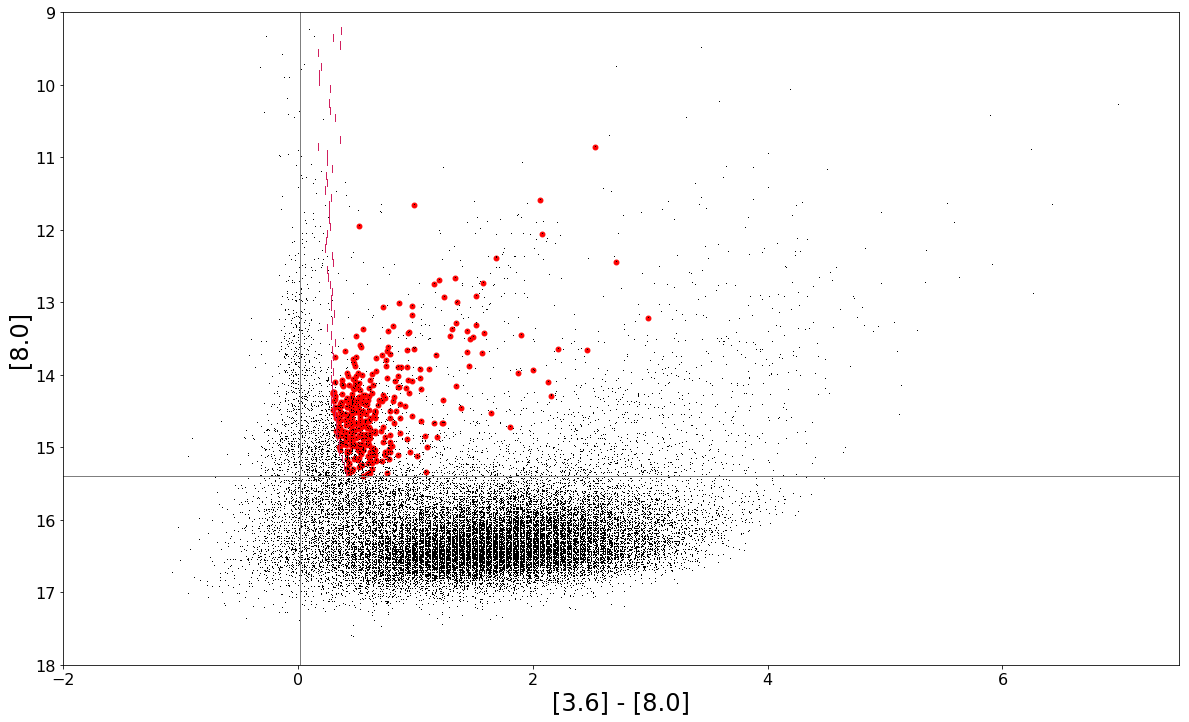

In [17]:
xaxis = threesixMINUSeightzero
yaxis = eightzero

x_flag_8 = in8_threesixMINUSeightzero
y_flag_8 = in8_eightzero

x_flags = [x_flag_8]
y_flags = [y_flag_8]

plot_CMD(xaxis, yaxis, 'black', wide=True)

# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red'], legend=False, wide=True) # turned off legend because it's redundant

redlim = [0.3711409973215888, 0.30097809756457605, 0.35941125496954285, 0.17, 9999, 0.19826699071362391, 
          0.18155494421403515, 0.1842626692942798, 0.2745584412271571, 9999, 0.26530073656834885, 
          0.272651461195151, 0.31928552015092915, 9999, 9999, 0.36205262752974143, 0.17, 0.25252019000527776, 
          0.24707130299064803, 0.295659679907019, 0.24320302549483297, 0.2537867860719714, 0.22868236931069777, 
          0.2851997273543948, 0.2685502607055788, 0.265899974389507, 0.2661298512232694, 0.27599045756789276, 
          0.25218923806570537, 0.242759264797387, 0.23297381391024516, 0.28955472746417554, 0.3017461462368922, 
          0.2485548926578606, 0.2562745719249429, 0.2776816963099864, 0.2926236494851574, 0.2816920066016876, 
          0.28347399431682363, 0.3062331627082658, 0.2912372550650325, 0.24854716429198767, 0.28764476067096034, 
          0.3182464457801656, 0.2914889006326318, 0.297582181808883, 0.2847097180473308, 0.2967128013232641, 
          0.28718405192714985, 0.28915906824344656, 0.2995616933161593, 0.28148744167643525, 0.2967303630105198, 
          0.3145362590173688, 0.3277434278418603, 0.32970047124248136, 0.3385771369566549, 0.3483970148417759, 
          0.35543241530515557, 0.3817538916644956, 0.3934004706813496, 0.4139654856494842, 0.4288233506709599, 
          0.4362222360199802, 0.46926939674728463, 0.4906692627488499, 0.5255634923149786, 0.5512234485205098, 
          0.581353003110552, 0.6128607776792353, 0.6411304961031976, 0.6811169392682088, 0.7045750673163891, 
          0.7361914450819849, 0.7693498463628727, 0.7995160417420225, 0.821946819161758, 0.832160297816502, 
          0.8525772679048065, 0.8587742126370141, 0.9124415187293639, 0.8966151513467823, 0.8884191681710157, 
          9999, 0.8607936056393024, 9999, 9999, 9999]

# Note that the first few nan values have been removed & y1 adjusted accordingly, but the rest have been turned into
#  9999, so that they hold the position in the list but aren't plotted visibly

y1 = 9.2
plt.axhline(y=15.4, linewidth=1, c='#7f7f7f')
plt.axvline(x=0.02, linewidth=1, c='#7f7f7f')

for x in redlim[:62]:
    plt.plot((x,x), (y1, y1+0.1), c='#d0205e', linewidth='1')
    y1 = y1 + 0.1

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/[8.0]_vs_[3.6]-[8.0]_wide.pdf')

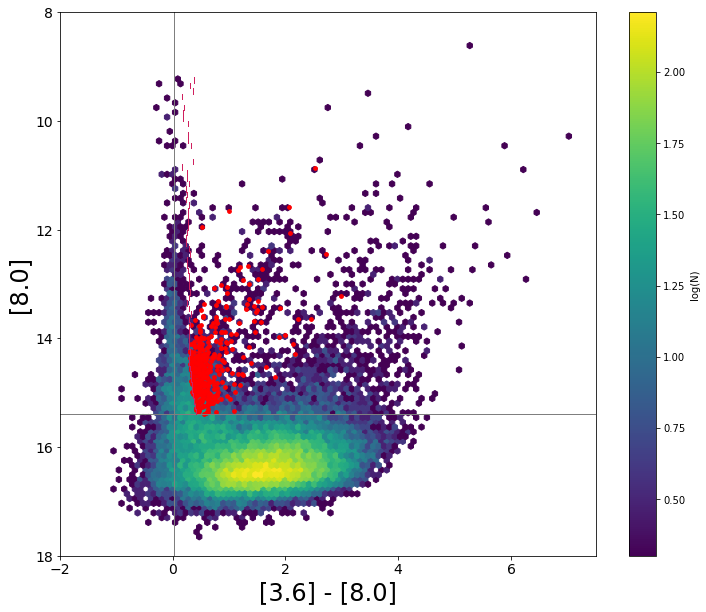

In [18]:
plot_hess(threesixMINUSeightzero, eightzero)

x_flag_8 = in8_threesixMINUSeightzero
y_flag_8 = in8_eightzero

x_flags = [x_flag_8]
y_flags = [y_flag_8]

# Red candidate layers 
plot_red_layers(x_flags, y_flags, colors=['red'], legend=False)

redlim = [0.3711409973215888, 0.30097809756457605, 0.35941125496954285, 0.17, 9999, 0.19826699071362391, 
          0.18155494421403515, 0.1842626692942798, 0.2745584412271571, 9999, 0.26530073656834885, 
          0.272651461195151, 0.31928552015092915, 9999, 9999, 0.36205262752974143, 0.17, 0.25252019000527776, 
          0.24707130299064803, 0.295659679907019, 0.24320302549483297, 0.2537867860719714, 0.22868236931069777, 
          0.2851997273543948, 0.2685502607055788, 0.265899974389507, 0.2661298512232694, 0.27599045756789276, 
          0.25218923806570537, 0.242759264797387, 0.23297381391024516, 0.28955472746417554, 0.3017461462368922, 
          0.2485548926578606, 0.2562745719249429, 0.2776816963099864, 0.2926236494851574, 0.2816920066016876, 
          0.28347399431682363, 0.3062331627082658, 0.2912372550650325, 0.24854716429198767, 0.28764476067096034, 
          0.3182464457801656, 0.2914889006326318, 0.297582181808883, 0.2847097180473308, 0.2967128013232641, 
          0.28718405192714985, 0.28915906824344656, 0.2995616933161593, 0.28148744167643525, 0.2967303630105198, 
          0.3145362590173688, 0.3277434278418603, 0.32970047124248136, 0.3385771369566549, 0.3483970148417759, 
          0.35543241530515557, 0.3817538916644956, 0.3934004706813496, 0.4139654856494842, 0.4288233506709599, 
          0.4362222360199802, 0.46926939674728463, 0.4906692627488499, 0.5255634923149786, 0.5512234485205098, 
          0.581353003110552, 0.6128607776792353, 0.6411304961031976, 0.6811169392682088, 0.7045750673163891, 
          0.7361914450819849, 0.7693498463628727, 0.7995160417420225, 0.821946819161758, 0.832160297816502, 
          0.8525772679048065, 0.8587742126370141, 0.9124415187293639, 0.8966151513467823, 0.8884191681710157, 
          9999, 0.8607936056393024, 9999, 9999, 9999]

# Note that the first few nan values have been removed & y1 adjusted accordingly, but the rest have been turned into
#  9999, so that they hold the position in the list but aren't plotted visibly

y1 = 9.2
plt.axhline(y=15.4, linewidth=1, c='#7f7f7f')
plt.axvline(x=0.02, linewidth=1, c='#7f7f7f')

for x in redlim[:62]:
    plt.plot((x,x), (y1, y1+0.1), c='#d0205e', linewidth='1')
    y1 = y1 + 0.1

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/[8.0]_vs_[3.6]-[8.0]_hess.pdf')

## 1 fig w/ all 8 CMDs (2x4)

### 2x4

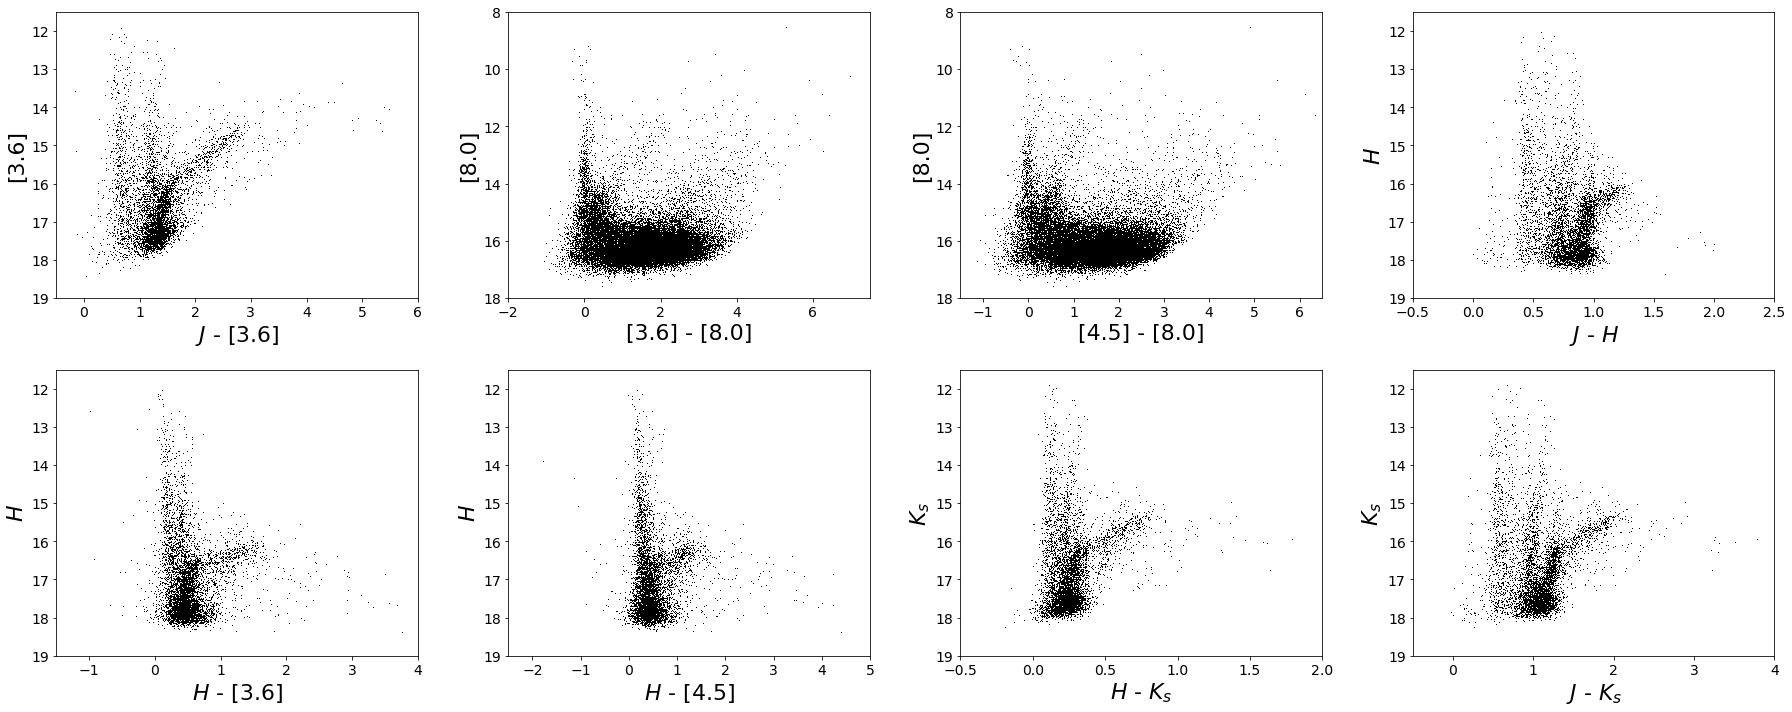

In [19]:
x_axes = [jMINUSthreesix, threesixMINUSeightzero, fourfiveMINUSeightzero, jMINUSh, hMINUSthreesix, hMINUSfourfive, 
         hMINUSk, jMINUSk]
y_axes = [threesix, eightzero, eightzero, Hmag, Hmag, Hmag, Kmag, Kmag]

x_labels = ['$J$ - [3.6]', '[3.6] - [8.0]', '[4.5] - [8.0]', '$J$ - $H$', '$H$ - [3.6]', '$H$ - [4.5]', 
            '$H$ - $K_s$', '$J$ - $K_s$']
y_labels = ['[3.6]', '[8.0]', '[8.0]', '$H$', '$H$', '$H$', '$K_s$', '$K_s$']

x_1 = [-0.5, -2.0, -1.5, -0.5, -1.5, -2.5, -0.5, -0.5]
x_2 = [6.0, 7.5, 6.5, 2.5, 4.0, 5.0, 2.0, 4.0]

y_1 = [11.5, 8.0, 8.0, 11.5, 11.5, 11.5, 11.5, 11.5]
y_2 = [19.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0, 19.0]

fig, axes = plt.subplots(2,4, figsize=(25,10)) # 2x4 layout
axes = axes.flat

for n, ax in enumerate(axes):
    ax.plot(x_axes[n],y_axes[n],',', color='black')
    ax.set_xlim(x_1[n], x_2[n])
    ax.set_ylim(y_2[n], y_1[n])
    ax.set_xlabel(x_labels[n], size=22)
    ax.set_ylabel(y_labels[n], size=22)
    ax.tick_params(labelsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.25, wspace=0.25)

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/8CMDs_2x4.pdf')

### 4x2

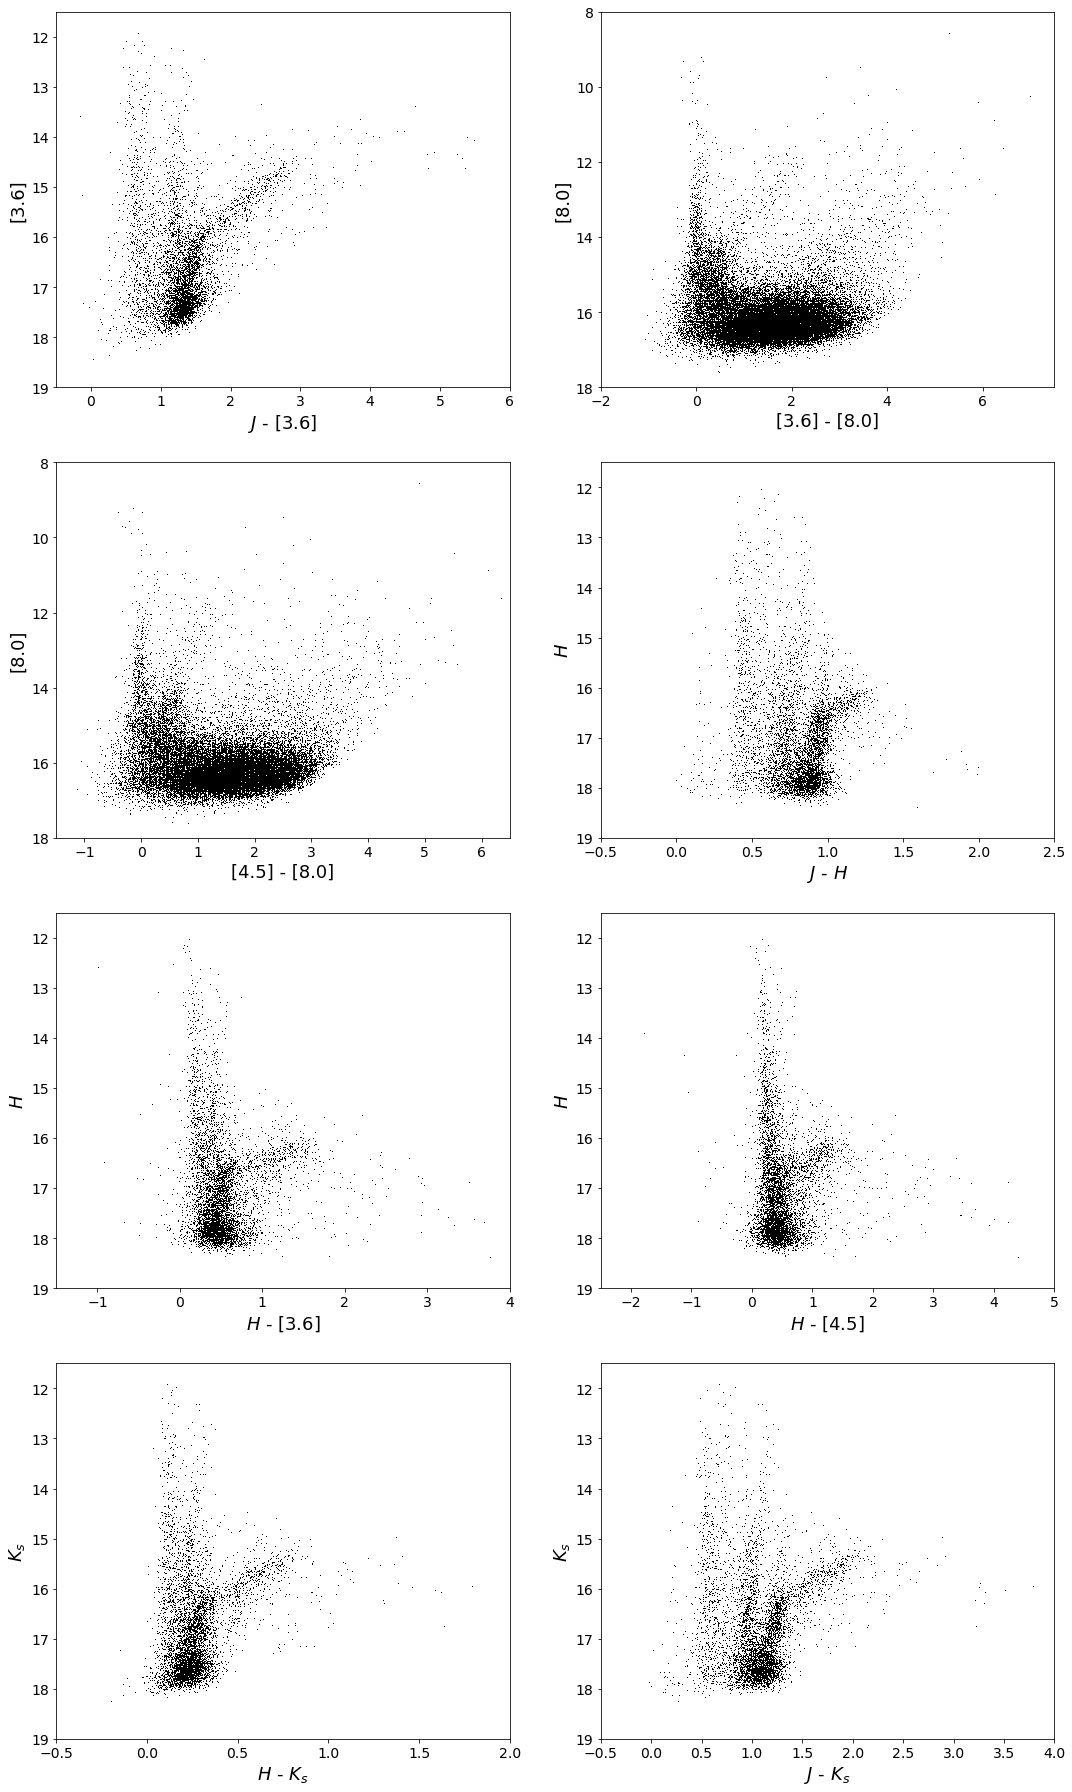

In [20]:
x_axes = [jMINUSthreesix, threesixMINUSeightzero, fourfiveMINUSeightzero, jMINUSh, hMINUSthreesix, hMINUSfourfive, 
         hMINUSk, jMINUSk]
y_axes = [threesix, eightzero, eightzero, Hmag, Hmag, Hmag, Kmag, Kmag]

x_labels = ['$J$ - [3.6]', '[3.6] - [8.0]', '[4.5] - [8.0]', '$J$ - $H$', '$H$ - [3.6]', '$H$ - [4.5]', 
            '$H$ - $K_s$', '$J$ - $K_s$']
y_labels = ['[3.6]', '[8.0]', '[8.0]', '$H$', '$H$', '$H$', '$K_s$', '$K_s$']

x_1 = [-0.5, -2.0, -1.5, -0.5, -1.5, -2.5, -0.5, -0.5]
x_2 = [6.0, 7.5, 6.5, 2.5, 4.0, 5.0, 2.0, 4.0]

y_1 = [11.5, 8.0, 8.0, 11.5, 11.5, 11.5, 11.5, 11.5]
y_2 = [19.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0, 19.0]


fig, axes = plt.subplots(4,2, figsize=(15,25)) # 4x2 layout
axes = axes.flat

for n, ax in enumerate(axes):
    ax.plot(x_axes[n],y_axes[n],',', color='black')
    ax.set_xlim(x_1[n], x_2[n])
    ax.set_ylim(y_2[n], y_1[n])
    ax.set_xlabel(x_labels[n], size=18)
    ax.set_ylabel(y_labels[n], size=18)
    ax.tick_params(labelsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/8CMDs_4x2.pdf')

### 3x3

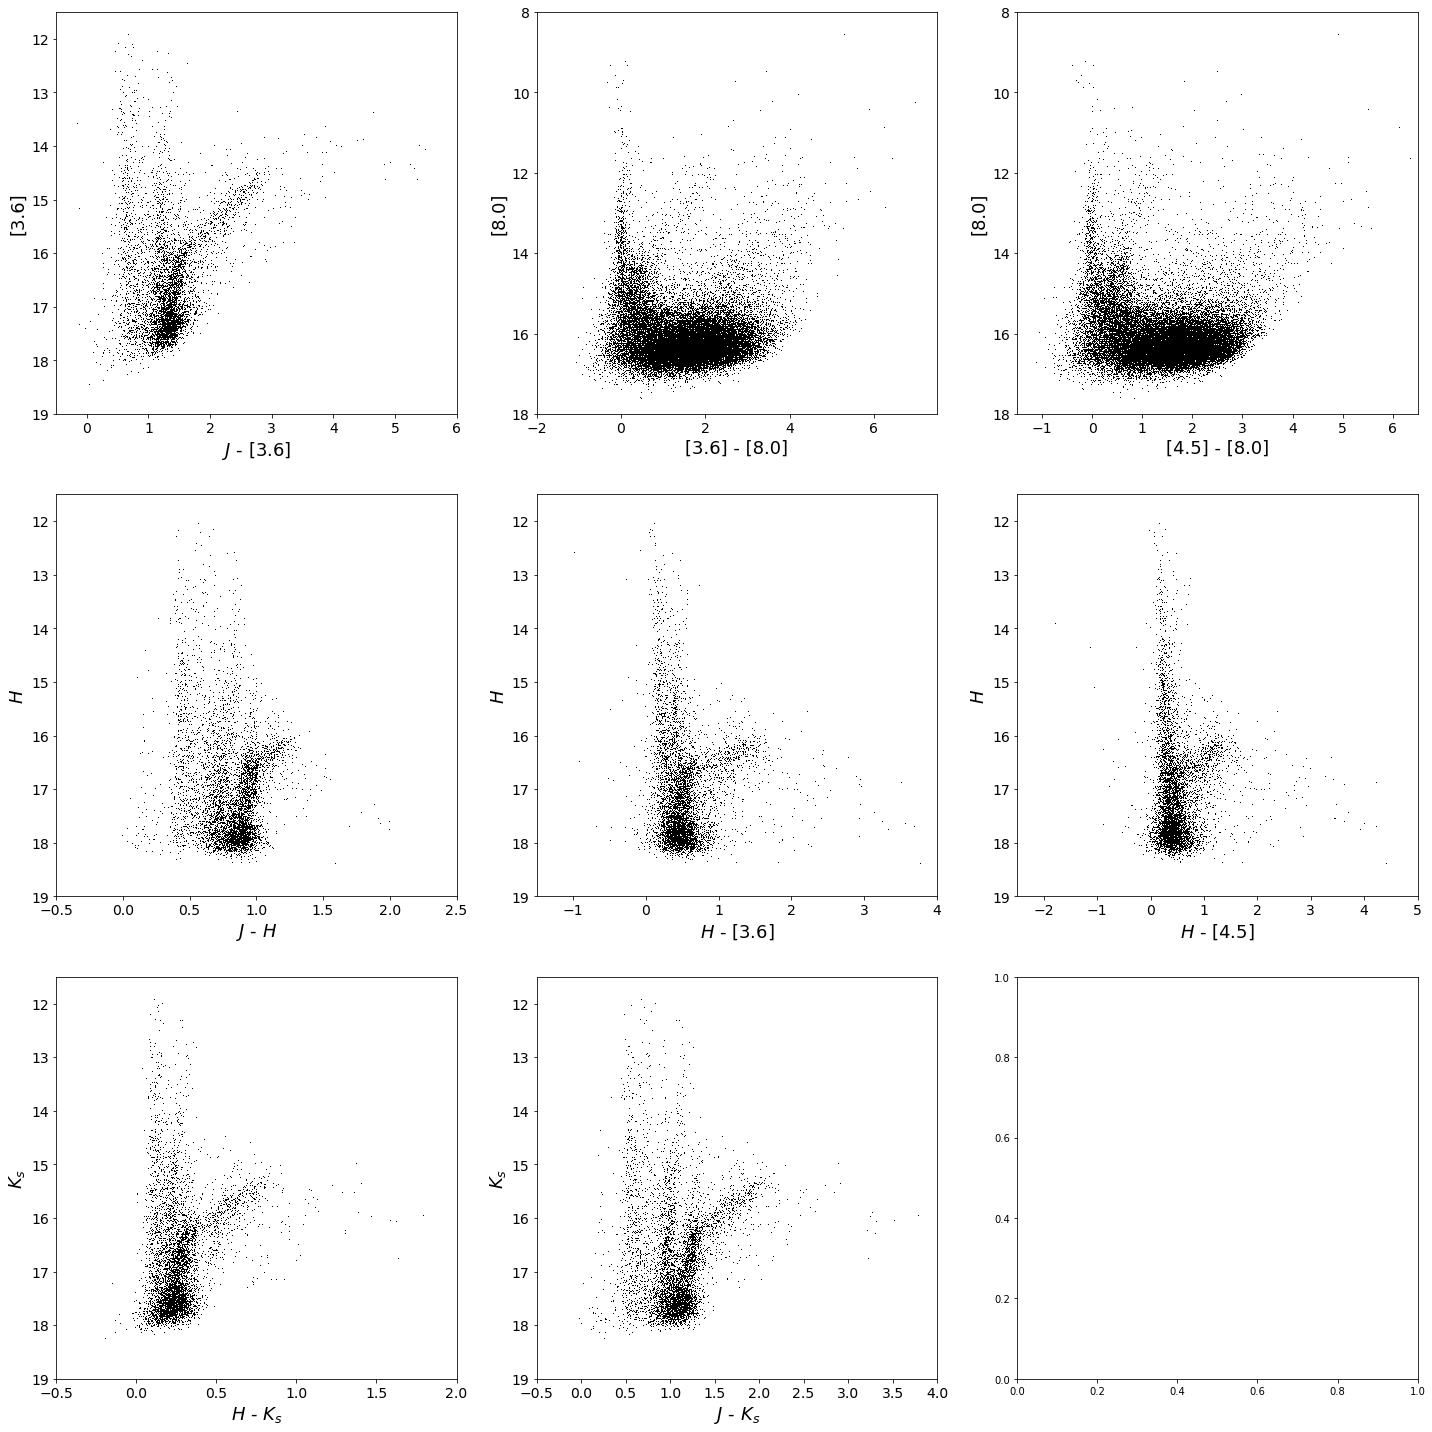

In [21]:
x_axes = [jMINUSthreesix, threesixMINUSeightzero, fourfiveMINUSeightzero, jMINUSh, hMINUSthreesix, hMINUSfourfive, 
         hMINUSk, jMINUSk]
y_axes = [threesix, eightzero, eightzero, Hmag, Hmag, Hmag, Kmag, Kmag]

x_labels = ['$J$ - [3.6]', '[3.6] - [8.0]', '[4.5] - [8.0]', '$J$ - $H$', '$H$ - [3.6]', '$H$ - [4.5]', 
            '$H$ - $K_s$', '$J$ - $K_s$']
y_labels = ['[3.6]', '[8.0]', '[8.0]', '$H$', '$H$', '$H$', '$K_s$', '$K_s$']

x_1 = [-0.5, -2.0, -1.5, -0.5, -1.5, -2.5, -0.5, -0.5]
x_2 = [6.0, 7.5, 6.5, 2.5, 4.0, 5.0, 2.0, 4.0]

y_1 = [11.5, 8.0, 8.0, 11.5, 11.5, 11.5, 11.5, 11.5]
y_2 = [19.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0, 19.0]


fig, axes = plt.subplots(3,3, figsize=(20,20)) # 3x3 layout
axes = axes.flat

for n, ax in enumerate(axes):
    if n < 8:
        ax.plot(x_axes[n],y_axes[n],',', color='black')
        ax.set_xlim(x_1[n], x_2[n])
        ax.set_ylim(y_2[n], y_1[n])
        ax.set_xlabel(x_labels[n], size=18)
        ax.set_ylabel(y_labels[n], size=18)
        ax.tick_params(labelsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/8Aug2018/8CMDs_3x3.pdf')